In [65]:
from pysal.contrib.spint.gravity import  BaseGravity, Gravity, Production, Attraction, Doubly
import pysal as ps
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%pylab inline
from descartes import PolygonPatch
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import pyproj as pj
from shapely.geometry import Polygon, Point

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [45]:
#Load NYC bike data - trips between census tract centroids
bikes = pd.read_csv(ps.examples.get_path('nyc_bikes_ct.csv'))
bikes.head()

,Unnamed: 0,index,count,d_cap,d_tract,distance,end station latitude,end station longitude,o_cap,o_tract,...,weighted,total_out,total_in,o_hub,d_hub,od_hub,SX,SY,EX,EY
0,0,0,5709,255.0,600,NaN,40.712899,-73.989865,162.0,202,...,0.0,56352,69165,hub,hub,hub,585995.353038,4.507417e+06,585322.159723,4.507378e+06
1,1,1,4010,595.0,600,NaN,40.712899,-73.989865,774.0,700,...,0.0,160040,69165,hub,hub,hub,583785.918305,4.506573e+06,585322.159723,4.507378e+06
2,2,2,1906,170.0,600,NaN,40.712899,-73.989865,141.0,800,...,0.0,34254,69165,hub,hub,non_hub,585018.109713,4.507320e+06,585322.159723,4.507378e+06
3,3,3,1192,255.0,600,NaN,40.712899,-73.989865,291.0,900,...,0.0,46446,69165,hub,hub,non_hub,583444.520998,4.506199e+06,585322.159723,4.507378e+06
4,4,4,484,85.0,600,NaN,40.712899,-73.989865,57.0,1002,...,0.0,15916,69165,hub,hub,non_hub,586462.456350,4.507937e+06,585322.159723,4.507378e+06


In [46]:
#Process data

#Remove intrazonal flows
bikes = bikes[bikes['o_tract'] != bikes['d_tract']]

#Set zero attirbute values to a small constant
bikes.ix[bikes.o_sq_foot == 0, 'o_sq_foot'] = 1
bikes.ix[bikes.d_sq_foot == 0, 'd_sq_foot'] = 1
bikes.ix[bikes.o_cap == 0, 'o_cap'] = 1
bikes.ix[bikes.d_cap == 0, 'd_cap'] = 1
bikes.ix[bikes.o_housing == 0, 'o_housing'] = 1
bikes.ix[bikes.d_housing == 0, 'd_housing'] = 1

#Flows between tracts
flows = bikes['count'].values.reshape((-1,1))

#Origin variables: square footage of buildings, housing units, total station capacity
o_vars = np.hstack([bikes['o_sq_foot'].values.reshape((-1,1)),
                    bikes['o_housing'].values.reshape((-1,1)),
                    bikes['o_cap'].values.reshape((-1,1))])

#Destination variables: square footage of buildings, housing units, total station capacity
d_vars = np.hstack([bikes['d_sq_foot'].values.reshape((-1,1)),
                    bikes['d_housing'].values.reshape((-1,1)),
                    bikes['d_cap'].values.reshape((-1,1))])

#Trip "cost" in time (seconds)
cost = bikes['tripduration'].values.reshape((-1,1))

#Origin ids
o = bikes['o_tract'].astype(str).values.reshape((-1,1))

#destination ids
d = bikes['d_tract'].astype(str).values.reshape((-1,1))

print len(bikes), ' OD pairs between census tracts after filtering out intrazonal flows'

14042  OD pairs between census tracts after filtering out intrazonal flows


In [47]:
#First we fit a basic gravity model and examine the parameters and model fit

grav= Gravity(flows, o_vars, d_vars, cost, 'exp')

print grav.params[1:] #truncate to exclude intercept

print 'Adjusted psuedo R2: ', grav.adj_pseudoR2
print 'Adjusted D2: ', grav.adj_D2
print 'SRMSE: ', grav.SRMSE
print 'Sorensen similarity index: ', grav.SSI

[ 0.06902469  0.04276277  0.50930082  0.03932893  0.04896158  0.39933316
 -0.00227255]
Adjusted psuedo R2:  0.773381464743
Adjusted D2:  0.778812957964
SRMSE:  0.916652445046
Sorensen similarity index:  0.745218330499


In [48]:
#Next we fit a production-constrained model

prod = Production(flows, o, d_vars, cost, 'exp')

print prod.params[-4:] #truncate to exclude balancing factors/fixed effects/ and intercept

print 'Adjusted psuedo R2: ', prod.adj_pseudoR2
print 'Adjusted D2: ', prod.adj_D2
print 'SRMSE: ', prod.SRMSE
print 'Sorensen similarity index: ', prod.SSI

[ 0.00437122  0.06794379  0.85720958 -0.00227555]
Adjusted psuedo R2:  0.832399632692
Adjusted D2:  0.836963213886
SRMSE:  0.794147843751
Sorensen similarity index:  0.777965361121


In [49]:
#Next we fit an attraction-constrained model

att = Attraction(flows, d, o_vars, cost, 'exp')

print att.params[-4:] #truncate to exclude balancing factors/fixed effects and intercept

print 'Adjusted psuedo R2: ', att.adj_pseudoR2
print 'Adjusted D2: ', att.adj_D2
print 'SRMSE: ', att.SRMSE
print 'Sorensen similarity index: ', att.SSI

[ 0.05281568  0.05689814  0.85161213 -0.00229343]
Adjusted psuedo R2:  0.83252844463
Adjusted D2:  0.837094085853
SRMSE:  0.792604389867
Sorensen similarity index:  0.777557481635


In [50]:
#Finally, we fit the doubly constrained model

doub = Doubly(flows, o, d, cost, 'exp')

print doub.params[-1:] #truncate to exclude balancing factors/fixed effects and intercept

print 'Adjusted psuedo R2: ', doub.adj_pseudoR2
print 'Adjusted D2: ', doub.adj_D2
print 'SRMSE: ', doub.SRMSE
print 'Sorensen similarity index: ', doub.SSI

[-0.00232112]
Adjusted psuedo R2:  0.895575966583
Adjusted D2:  0.90034221928
SRMSE:  0.627981455879
Sorensen similarity index:  0.818294076455


In [51]:
#We can also estimate a local model which subsets the data
#For a production constrained model this means each local model
#is from one origin to all destinations. Since we get a set of 
#parameter estimates for each origin, we can then map them.

local_prod = prod.local()

In [52]:
#There is a set of local parameter estimates, tvalues, and pvalues for each covariate
#And there is a set of local values for each diagnostic

local_prod.keys()

['pvalue2',
 'pvalue3',
 'pvalue0',
 'pvalue1',
 'stde1',
 'stde0',
 'stde3',
 'stde2',
 'adj_pseudoR2',
 'AIC',
 'SRMSE',
 'SSI',
 'adj_D2',
 'deviance',
 'tvalue2',
 'tvalue3',
 'tvalue0',
 'tvalue1',
 'param3',
 'param2',
 'param1',
 'param0',
 'D2',
 'pseudoR2']

In [53]:
#Prep geometry for plotting

#Read in census tracts for NYC
crs = {'datum':'WGS84', 'proj':'longlat'}
tracts = ps.examples.get_path('nyct2010.shp')
tracts = gp.read_file(tracts)
tracts = tracts.to_crs(crs=crs)

#subset manhattan tracts
man_tracts = tracts[tracts['BoroCode'] == '1'].copy()
man_tracts['CT2010S'] = man_tracts['CT2010'].astype(int).astype(str)

#Get tracts for which there are no onbservations
mt = set(man_tracts.CT2010S.unique())
lt = set(np.unique(o))
nt = list(mt.difference(lt))
no_tracts = pd.DataFrame({'no_tract':nt})
no_tracts = man_tracts[man_tracts.CT2010S.isin(nt)].copy()

#Join local values to census tracts
local_vals = pd.DataFrame({'betas': local_prod['param3'], 'tract':np.unique(o)})
local_vals = pd.merge(local_vals, man_tracts[['CT2010S', 'geometry']], left_on='tract', right_on='CT2010S')
local_vals = gp.GeoDataFrame(local_vals)



(40.7, 40.78)

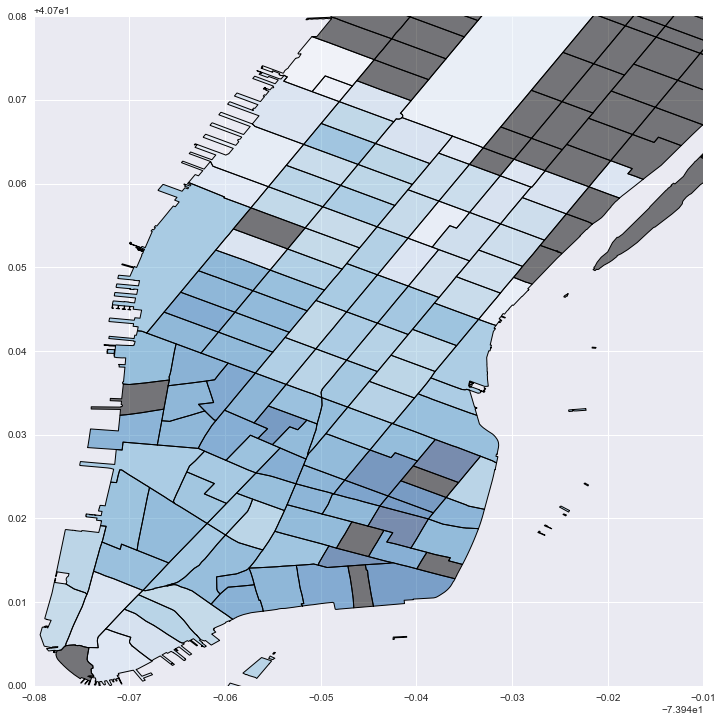

In [54]:
#Plot local "cost" values: darker blue is stronger distance decay; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['inv_betas'] = (local_vals['betas']*-1)
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('inv_betas', cmap='Blues', ax=ax)
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)


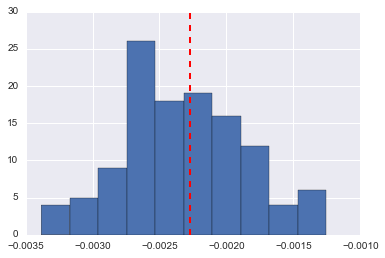

In [55]:
#Histogram of local distance decay parameters - red dashed line is the distance decay parameter from a global model
plt.hist(local_prod['param3'])
plt.axvline(prod.params[-1], color='r', linestyle='dashed', linewidth=2)
plt.show()

(40.7, 40.78)

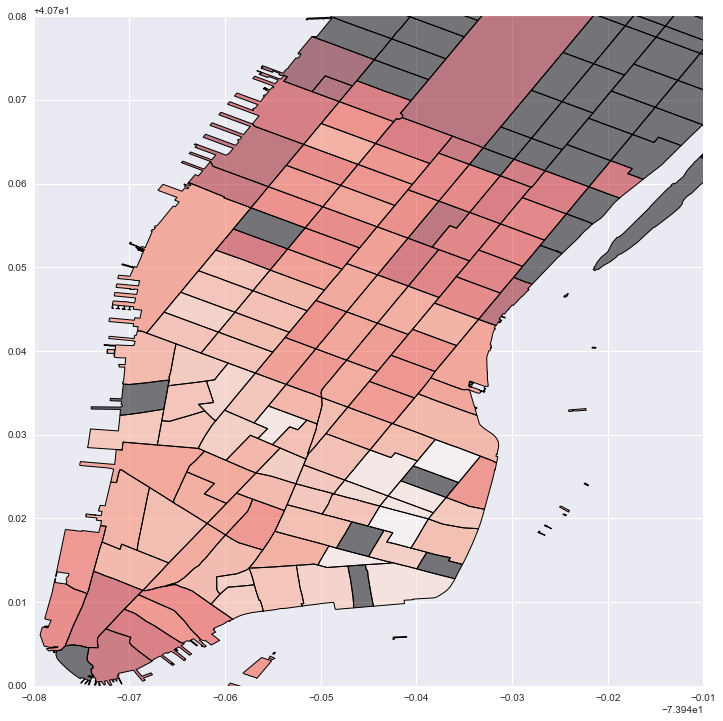

In [56]:
#Plot local estimates for destination station capacity: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['cap'] = local_prod['param3']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('cap', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

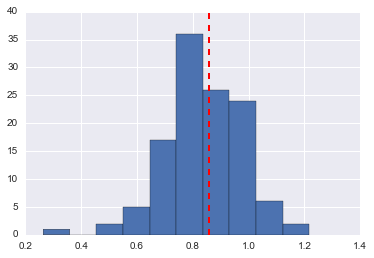

In [57]:
#Histogram of local destination station capacity parameters 
#red dashed line is the parameter from a global model
plt.hist(local_prod['param2'])
plt.axvline(prod.params[-2], color='r', linestyle='dashed', linewidth=2)
plt.show()

(40.7, 40.78)

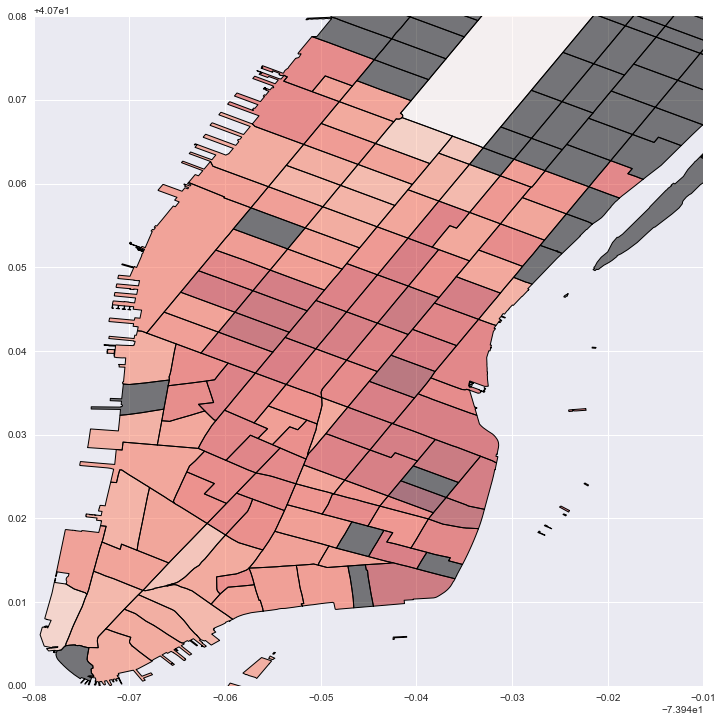

In [58]:
#Plot local estimates for # of housing units: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['house'] = local_prod['param2']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('house', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

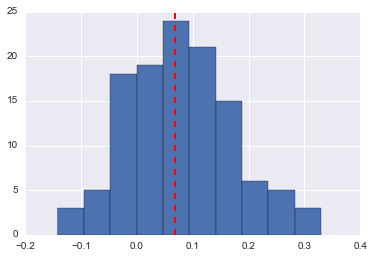

In [59]:
#Histogram of local # of housing units parameters 
#red dashed line is the parameter from a global model
plt.hist(local_prod['param1'])
plt.axvline(prod.params[-3], color='r', linestyle='dashed', linewidth=2)
plt.show()

(40.7, 40.78)

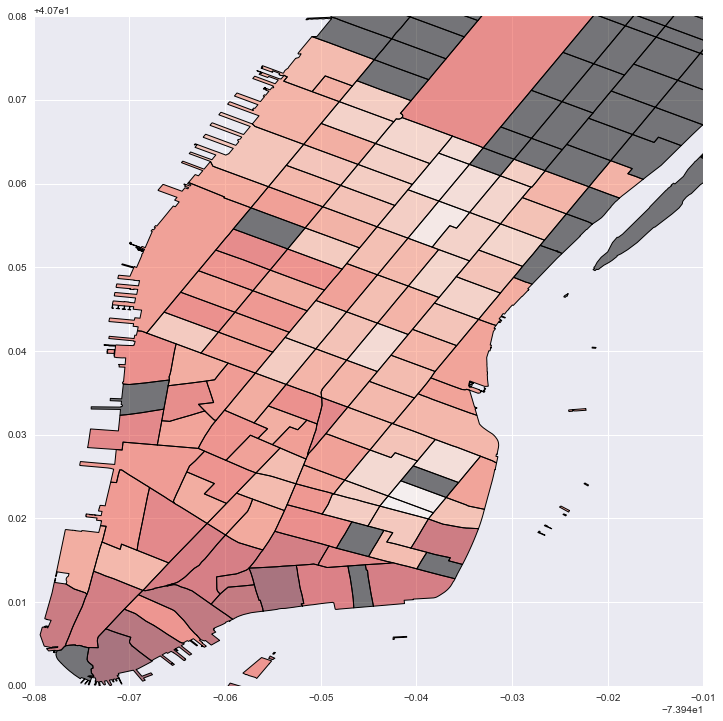

In [60]:
#Plot local estimates for destination building sq footage: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['foot'] = local_prod['param1']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('foot', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

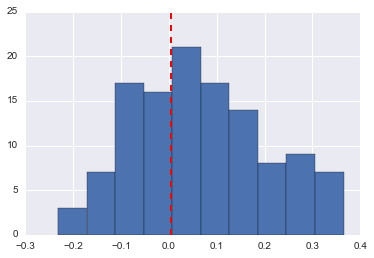

In [61]:
#Histogram of local destination building sq. footage parameters 
#red dashed line is the parameter from a global model
plt.hist(local_prod['param0'])
plt.axvline(prod.params[-4], color='r', linestyle='dashed', linewidth=2)
plt.show()

(40.7, 40.78)

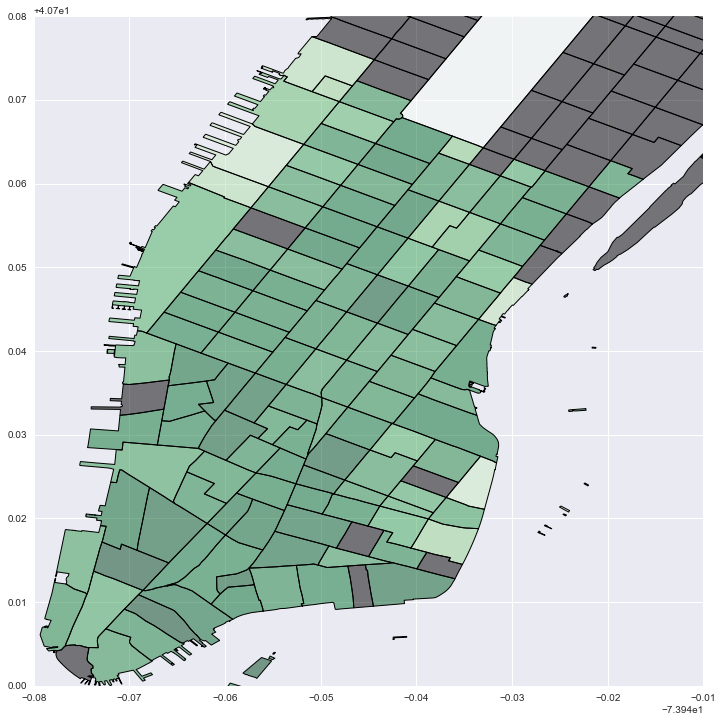

In [62]:
#Plot local estimates for pseudo R2: darker green is better model fit; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['r2'] = local_prod['pseudoR2']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('r2', cmap='Greens', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

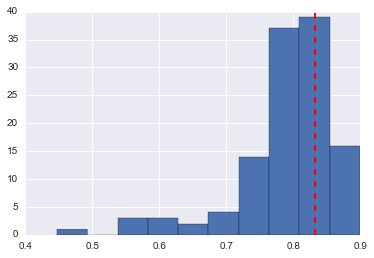

In [63]:
#Histogram of local pseudo R2 
#red dashed line is the pseudoR2 from a global model
plt.hist(local_prod['pseudoR2'])
plt.axvline(prod.pseudoR2, color='r', linestyle='dashed', linewidth=2)
plt.show()